In [36]:
import pandas as pd
import numpy as np
from structlog import get_logger
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tqdm import tqdm

logger = get_logger()

# Load Dataset

In [44]:
TRAIN_END_DATE = 424
TEST_END_DATE = 481

df = pd.read_csv('../archive/optiver2023/train.csv')
df_train = df[df['date_id'] <= TRAIN_END_DATE]
df_test = df[(df['date_id'] > TRAIN_END_DATE) & (df['date_id'] <= TEST_END_DATE)]

# sort the data by stock_id, date_id, seconds_in_bucket
df_train = df_train.sort_values(by=['stock_id', 'date_id', 'seconds_in_bucket'])
df_test = df_test.sort_values(by=['stock_id', 'date_id', 'seconds_in_bucket'])

In [15]:
days_to_filter = set()
for (date_id, seconds_in_bucket), stock_ids in df_train.groupby(['date_id', 'seconds_in_bucket'])['stock_id']:
    breakpoint()
    if len(stock_ids) != 200:
        days_to_filter.add(date_id)   

# remove days with less than 200 stock_ids
df_train = df_train[~df_train['date_id'].isin(days_to_filter)]
df_train.groupby(['date_id', 'seconds_in_bucket']).size().value_counts()


days_to_filter = set()
for (date_id, seconds_in_bucket), stock_ids in df_test.groupby(['date_id', 'seconds_in_bucket'])['stock_id']:
    breakpoint()
    if len(stock_ids) != 200:
        days_to_filter.add(date_id)   

# remove days with less than 200 stock_ids
df_test = df_test[~df_test['date_id'].isin(days_to_filter)]
df_test.groupby(['date_id', 'seconds_in_bucket']).size().value_counts()

200    3080
Name: count, dtype: int64

In [16]:
len(df_train), len(df_test)

(1419000, 616000)

In [38]:
def get_data(df):
    num_stocks = df["stock_id"].nunique()
    num_dates = df["date_id"].nunique()
    num_updates = df["seconds_in_bucket"].nunique()

    num_dates_map = {v:i for i, v in enumerate(sorted(df["date_id"].unique()))}
    breakpoint()

    print(f"# stocks         : {num_stocks}")
    print(f"# dates          : {num_dates}")
    print(f"# updates per day: {num_updates}")

    breakpoint()
    stock_returns = np.zeros((num_stocks, num_dates, num_updates))
    index_returns = np.zeros((num_stocks, num_dates, num_updates))


    for (stock_id, date_id), frame in tqdm(df.groupby(["stock_id", "date_id"])):
        frame["stock_return"] = (frame["wap"] / frame["wap"].shift(6)).shift(-6) * 10_000
        frame["index_return"] = frame["stock_return"] - frame["target"]
        breakpoint()

        stock_returns[stock_id, num_dates_map[date_id]] = frame["stock_return"].values
        index_returns[stock_id, num_dates_map[date_id]] = frame["index_return"].values

    index_return = np.mean(index_returns, axis=0) # 10000 * index_return_t+60

    y = index_return.reshape(-1)
    X = stock_returns.reshape((num_stocks, -1)).T
    # mask = ~((np.isnan(y) | np.isnan(X).any(axis=1)))
    # X, y = X[mask], y[mask]
    return X, y

X_train, y_train = get_data(df_train)
X_test, y_test = get_data(df_test)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

# stocks         : 200
# dates          : 425
# updates per day: 55


100%|██████████| 84036/84036 [00:28<00:00, 2939.90it/s]


# stocks         : 200
# dates          : 56
# updates per day: 55


100%|██████████| 11200/11200 [00:03<00:00, 2917.74it/s]


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [28]:
print("Fit ".center(80, ">"))
print("Sum of Coef:", lr.coef_.sum())
print("Intercept:", lr.intercept_)
print("Train R2:", r2_score(y_train, y_pred_train))
print("Train MSE:", mean_squared_error(y_train, y_pred_train))
print("Test R2:", r2_score(y_test, y_pred_test))
print("Test MSE:", mean_squared_error(y_test, y_pred_test))

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Fit >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Sum of Coef: 1.0016366870113351
Intercept: -16.366904249331128
Train R2: 0.9999997492637379
Train MSE: 0.0037985915291011774
Test R2: 0.9998318439218082
Test MSE: 0.002885849594851249


In [29]:
print("Coef:", lr.coef_)

Coef: [0.00390747 0.00094    0.00193844 0.00636099 0.00404473 0.00407181
 0.00192418 0.0060503  0.00582268 0.00246783 0.00198957 0.00788853
 0.00664465 0.00195512 0.00822393 0.00619615 0.00202353 0.005923
 0.00404154 0.00189737 0.00389136 0.00085956 0.00591612 0.00416779
 0.00173364 0.00180818 0.0039261  0.0020838  0.00375153 0.00414601
 0.00070243 0.00093752 0.00197963 0.00204758 0.00572611 0.00390222
 0.00391234 0.00430209 0.006308   0.00214506 0.00191361 0.0398809
 0.00202012 0.00214102 0.00413237 0.03985863 0.00191307 0.00089706
 0.00577985 0.00366877 0.00387718 0.00599127 0.00083079 0.0039452
 0.00422445 0.00199823 0.00600354 0.00367991 0.0058532  0.00392075
 0.00612145 0.00376206 0.00213056 0.00090106 0.00189418 0.00380647
 0.00199971 0.00788608 0.00381713 0.00402751 0.00204193 0.00392387
 0.00600168 0.0049989  0.00392843 0.00415293 0.00152047 0.00388065
 0.00499954 0.00499966 0.00095732 0.0019807  0.00195441 0.00777406
 0.02015629 0.00376059 0.00587189 0.00210308 0.01979462 0.00

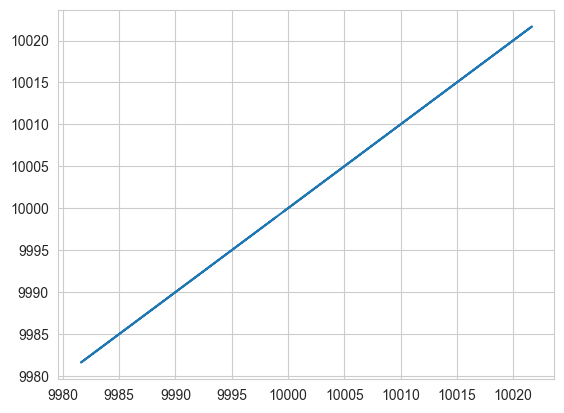

In [23]:
plt.plot(y_test, y_pred_test)

# Check if we can know the weights for the index

In [30]:
WEIGHTS = lr.coef_
intercept = lr.intercept_

In [45]:
WEIGHTS = np.loadtxt('index_return_coef.csv', delimiter=',')[:, 1]
intercept = WEIGHTS[-1]
WEIGHTS = WEIGHTS[:-1]

In [41]:
def compute_index(df):
    i = 0
    for _, records  in tqdm(df.groupby(['date_id', 'seconds_in_bucket'])):
        curr_x = records['wap_t+60'] / records['wap'] * 10_000
        if curr_x.size != 200:
            continue
        index_wap = np.dot(WEIGHTS, curr_x) + intercept # 10000 * index_return_t+60
        if i == 0:
            print(index_wap)
            i += 1
        df.loc[records.index, 'index_wap'] = [index_wap] * records.index.size

    return df

In [33]:
df_train['wap_t+60'] = df_train.groupby(['stock_id', 'date_id'])['wap'].shift(-6)
df_train = df_train.dropna(subset=['wap', 'wap_t+60'])
df_train = compute_index(df_train)
df_train = df_train.sort_values(by=["stock_id", "date_id", "seconds_in_bucket"])

 65%|██████▌   | 13577/20825 [00:01<00:00, 12081.18it/s]

10001.257814038556


100%|██████████| 20825/20825 [00:03<00:00, 6752.62it/s] 


In [28]:
df_train["predicted_target"] = df_train["wap_t+60"] / df_train["wap"] * 10000 - df_train["index_wap"]
df_train = df_train[~df_train["predicted_target"].isna()]

print(mean_squared_error(df_train['predicted_target'], df_train['target']))
print(mean_absolute_error(df_train['predicted_target'], df_train['target']))
print(r2_score(df_train['predicted_target'], df_train['target']))

2.492814863023814e-05
0.004051465886805681
0.9999997278440389


In [46]:
def compute_index(df):
    i = 0
    for _, records  in tqdm(df.groupby(['date_id', 'seconds_in_bucket'])):
        curr_x = records['wap_t+60'] / records['wap'] * 10_000
        if curr_x.size != 200:
            continue
        index_wap = np.dot(WEIGHTS, curr_x) + intercept # 10000 * index_return_t+60
        if i == 0:
            print(index_wap)
            i += 1
        df.loc[records.index, 'index_wap'] = [index_wap] * records.index.size

    return df

df_test['wap_t+60'] = df_test.groupby(['stock_id', 'date_id'])['wap'].shift(-6)
# df_test = df_test.dropna(subset=['wap', 'wap_t+60'])
df_test = compute_index(df_test)
df_test = df_test.sort_values(by=["stock_id", "date_id", "seconds_in_bucket"])
df_test["predicted_target"] = df_test["wap_t+60"] / df_test["wap"] * 10000 - df_test["index_wap"]
df_test = df_test[~df_test["predicted_target"].isna()]

print(mean_squared_error(df_test['target'], df_test['predicted_target']))
print(mean_absolute_error(df_test['target'], df_test['predicted_target']))
print(r2_score(df_test['target'], df_test['predicted_target']))

 18%|█▊        | 565/3080 [00:00<00:00, 3085.63it/s]

9999.563875370335


100%|██████████| 3080/3080 [00:00<00:00, 4002.35it/s]


0.0029105760416829564
0.04121442789361965
0.9999629278368903


In [47]:
df_test['predicted_target']

4621980    1.846125
4622180   -1.524412
4622380   -1.702987
4622580   -1.336180
4622780   -1.341822
             ...   
5235979    8.826575
5236179    8.970975
5236379    0.809504
5236579    0.740839
5236779    4.313910
Name: predicted_target, Length: 539000, dtype: float64

In [7]:
df_test

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id,wap_t+60,index_wap,predicted_target
4621980,0,425,0,7218754.93,-1,1.000062,22642235.17,NaN,NaN,0.999873,10813.75,1.000062,5276.00,1.000000,1.809597,23375,425_0_0,1.000141,9999.563875,1.846125
4622180,0,425,10,6166574.88,-1,1.000062,23694415.22,NaN,NaN,1.000062,28437.64,1.000252,10554.00,1.000200,-1.549721,23376,425_10_0,1.000120,10000.724572,-1.524412
4622380,0,425,20,6179553.04,-1,1.000252,23694415.22,NaN,NaN,1.000252,17889.03,1.000631,19321.14,1.000434,-1.710057,23377,425_20_0,1.000082,9998.184514,-1.702987
4622580,0,425,30,6513133.79,-1,1.000062,23694415.22,NaN,NaN,1.000062,29440.08,1.000252,17044.71,1.000182,-1.320243,23378,425_30_0,0.999920,9998.716657,-1.336180
4622780,0,425,40,6492927.96,-1,0.999873,23694415.22,NaN,NaN,0.999873,42411.00,1.000252,69867.48,1.000016,-1.339912,23379,425_40_0,0.999977,10000.951828,-1.341822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5235979,199,480,440,0.00,0,1.001812,23777108.28,1.001812,1.001812,1.001812,176332.95,1.002129,113363.52,1.002005,8.859634,26444,480_440_199,1.002835,9999.456817,8.826575
5236179,199,480,450,0.00,0,1.001812,23777108.28,1.001812,1.001812,1.001812,218925.45,1.002129,194251.80,1.001980,9.020567,26445,480_450_199,1.002974,10000.949383,8.970975
5236379,199,480,460,135671.59,-1,1.001812,23784351.66,1.001177,1.001812,1.001812,233186.05,1.002129,226222.08,1.001973,0.849962,26446,480_460_199,1.001982,9999.280319,0.809504
5236579,199,480,470,796236.05,-1,1.001812,23788288.28,1.001177,1.001494,1.001812,245774.50,1.002129,394815.60,1.001934,0.760555,26447,480_470_199,1.001993,9999.848022,0.740839


In [22]:
import csv

with open('index_return_coef.csv', 'w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)
    for i, weight in enumerate(WEIGHTS):
        writer.writerow([i, weight])
    writer.writerow([i + 1, intercept])